# README

### Overview

In this notebook, we construct the spot curve from the par yield curve with a process known as bootstrapping. We then construct the forward curve from the spot curve. Below is a description of each step along with the relevant formulas. Towards the bottom of the code, there is a graph showing all 3 curves.

### 1. Pulling the Par Yield Curve

We start by pulling the par yield curve from OpenBB. The par yield curve gives us the yields of treasury securities that are priced at par. Securities with maturities up to and including 1 year are zero-coupon but for longer maturities these securities will have semi-annual coupons. The par yield curve only gives us yields for a few select maturities: 1 month, 3 month, 6 month, 1 year, 2 year, 3 year, 5 year, 7 year, 10 year, 20 year, 30 year.

### 2. Interpolating the Par Yield Curve

To have a more granular set of yields, we linearly interpolate the par yield curve to obtain yields every 6 months. This allows us to estimate yields for maturities that are not directly available in the data.

### 3. Bootstrapping to Calculate Spot Rates

We want to construct the spot curve from the par yield curve. That is, for each maturity, we want to calculate the spot rate, which is simply the yield on a zero coupon bond of that maturity. These spot rates can be used to price bonds and other products.

To get spot rates from par yields, we use a technique called *bootstrapping*. The concept is simple. The value of a coupon-bearing security must be equal to the sum of the values of zero coupon securities that duplicate the bond's cashflows. In other words, you can think of each of the bond's coupons and principal repayment as a zero coupon security in itself. Note that we already know the 6-month and 1-year spot rate. Since securities with those maturities are zero coupon, the corresponding spot rate is just equal to the security's yield. From these first two spot rates, we will be able to sequentially calculate spot rates for maturities 1.5, 2, 2.5 etc.

Now we derive a formula to calculate the spot rate for each maturity. Assume we are trying to calculate the spot rate $ z_n $ with maturity $ t_n $. We already know all the previous spot rates $ z_1, z_2, ..., z_{n-1}$ for maturities $ t_1, t_2, ..., t_{n-1}$ which are spaced 6 months apart. Consider the coupon-bearing treasury security priced at par (call par 1 instead of 100 for ease) with maturity $ t_n $ and yield $ y_n $.  Since it's priced at par, it's coupon must equal to its yield. Since its price is the sum of the discounted cashflows we have:
$$ 1 = (1 + \frac{y_n}{2})(1 + z_n)^{-t_n} + \frac{y_n}{2} \sum_{i=1}^{n-1} (1 + z_i)^{-t_i} $$ 

On the LHS we have the price of the bond (which is 1 since it's trading at par). On the RHS, the first term is just the discounted principal payment and final coupon. The second term is the sum of all other discounted coupons. We know everything except $ z_n $. Explicitely rearranging for $ z_n $ gives us 
$$ z_n = \left( \frac{1 + \frac{y_n}{2}}{1 - \frac{y_n}{2} \sum_{i=1}^{n-1} (1 + z_i)^{-t_i}} \right)^\frac{1}{t_n} - 1$$

So since we know, the first two spot rates directly from the par curve, we can use this formula to calculate the third spot rate and continue sequentially, building up a whole curve.

### 4. Calculating Forward Rates from Spot Rates

From the spot curve, we can calculate forward rates which are expectations for interest rates in the future between two points in time. The basic principal behind calculating forward rates from spot rates comes from considering two alternative invesments. 

OPTION 1: Invest at a spot rate $ z_n $ for $ t_n $ years.

OPTION 2: Invest intially at a spot rate $ z_m $ for $ t_m $ years where $m < n$. Then reinvest the proceeds at some rate $ f_{m,n}$. 

Applying the no-arbitrage principal, for these two investments to have the same value we must have:

$$ (1 + z_n)^{t_n} = (1 + z_m)^{t_m}(1 + f_{m,n})^{t_{n}-t_{m}}$$

This rate $ f_{m,n}$ is called the $(t_m - t_n)$-year forward rate starting $m$ years in the future. It is an estimate of what the $(t_m - t_n)$-spot rate will be in $m$ years time. Rearranging for $f_{m,n}$ gives us

$$ f_{m,n} = \left( \frac{(1 + z_{n})^{t_n}}{(1 + z_{m})^{t_m}} \right) ^\frac{1}{t_{n}-t_{m}} - 1$$

Using this formula, we build up a forward curve where $m$ and $n$ are 6 months apart.

# Imports

In [43]:
%pip install -q openbb

Note: you may need to restart the kernel to use updated packages.


In [44]:
import pandas as pd
from openbb import obb
from kaggle_secrets import UserSecretsClient
import matplotlib.pyplot as plt
import numpy as np

# OpenBB Setup

In [45]:
# Get OpenBB personal access token
user_secrets = UserSecretsClient()
openbb_pat = user_secrets.get_secret("openbb_pat")

# Login to OpenBB with personal access token
obb.account.login(pat=openbb_pat, remember_me=False)

# Get Par Yield Curve

In [46]:
# Get Par Yield Curve
start_date = '2024-10-10'
end_date = '2024-10-10'
par_yield_curve = obb.fixedincome.government.treasury_rates(
    start_date=start_date,
    end_date=end_date
).to_df().reset_index().drop('date', axis=1)

In [47]:
par_yield_curve

,month_1,month_3,month_6,year_1,year_2,year_3,year_5,year_7,year_10,year_20,year_30
0,0.0498,0.0475,0.0445,0.0422,0.0398,0.0388,0.0391,0.0399,0.0409,0.0444,0.0438


In [48]:
# Convert maturity times to months
par_yield_curve.rename(
    {
        'month_1': 1,
        'month_3': 3,
        'month_6': 6,
        'year_1': 12,
        'year_2': 24,
        'year_3': 36,
        'year_5': 60,
        'year_7': 84,
        'year_10': 120,
        'year_20': 240,
        'year_30': 360
    },
    inplace=True,
    axis=1
)

# Unpivot data
par_yield_curve = pd.melt(
    frame=par_yield_curve,
    var_name='Month',
    value_name='Par Yield'
)

# Add year column
par_yield_curve['Year'] = par_yield_curve['Month'] / 12
par_yield_curve

,Month,Par Yield,Year
0,1,0.0498,0.083333
1,3,0.0475,0.250000
2,6,0.0445,0.500000
3,12,0.0422,1.000000
4,24,0.0398,2.000000
5,36,0.0388,3.000000
6,60,0.0391,5.000000
7,84,0.0399,7.000000
8,120,0.0409,10.000000
9,240,0.0444,20.000000


# Interpolate Par Yield Curve

In [49]:
# Perform linear interpolation to get a yield every momth
interpolated_par_yield_curve = par_yield_curve[['Month', 'Par Yield']].copy()
interpolated_par_yield_curve.set_index('Month', inplace=True)
new_index = np.arange(1, 361)
interpolated_par_yield_curve = interpolated_par_yield_curve.reindex(new_index).interpolate(method='linear')
interpolated_par_yield_curve.reset_index(drop=False, inplace=True)

# Add year column
interpolated_par_yield_curve['Year'] = interpolated_par_yield_curve['Month'] / 12

interpolated_par_yield_curve

,Month,Par Yield,Year
0,1,0.049800,0.083333
1,2,0.048650,0.166667
2,3,0.047500,0.250000
3,4,0.046500,0.333333
4,5,0.045500,0.416667
...,...,...,...
355,356,0.043820,29.666667
356,357,0.043815,29.750000
357,358,0.043810,29.833333
358,359,0.043805,29.916667


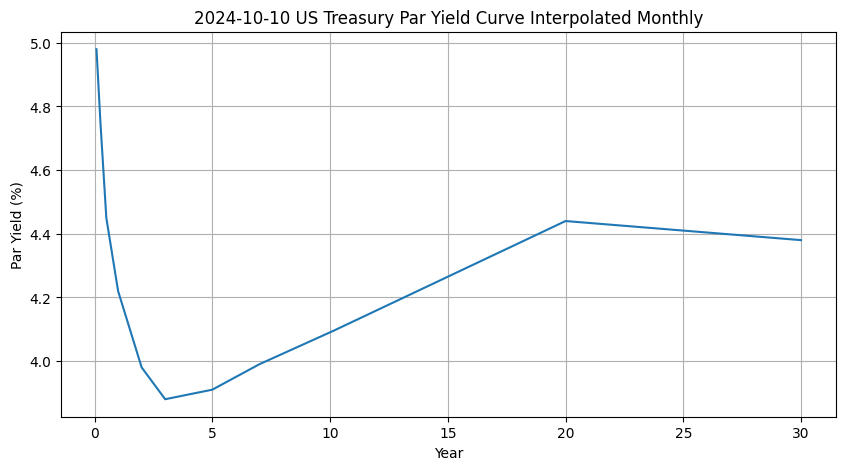

In [50]:
# Plot Par Yield Curve
plt.figure(figsize=(10, 5))
plt.plot(interpolated_par_yield_curve['Year'], 100 * interpolated_par_yield_curve['Par Yield'])
plt.title(f'{start_date} US Treasury Par Yield Curve Interpolated Monthly')
plt.xlabel('Year')
plt.ylabel('Par Yield (%)')
plt.grid()
plt.show()

# Construct Spot Curve via Bootstrapping

In [51]:
def bootstrap(
    par_yield_curve: pd.DataFrame
) -> pd.DataFrame:
    """
    Given the par yield curve, perform bootstrapping to get spot rates for the same maturities as the provided yield curve.
    The function assumes that the bonds have cashflows every 6 months and so the dataframe 'par_yield_curve' should have times 0.5, 1, 1.5 etc.
    """
    # Set up list to store spot rates and maturities
    spot_rates = []
    maturities = []
    
    # Calculate spot rate for each maturity via bootstrapping method
    for i, row in par_yield_curve.iterrows():
        # Get maturity
        maturity = row['Year']
        
        # Get par yield
        par_yield = row['Par Yield']
        
        # For maturities up to 1 year, the bonds are zero coupon so par yield = spot rate
        if maturity <= 1:
            spot_rate = row['Par Yield']
        else:
            # For longer maturities, we use the formula par price = sum of discounted cashflows and rearrange for spot rate
            prior_coupons = 0.5 * par_yield * sum(np.power(1 + s, -m) for s, m in zip(spot_rates, maturities))
            final_coupon_and_principal = 1 + (0.5 * par_yield)
            spot_rate = np.power(final_coupon_and_principal / (1 - prior_coupons), 1 / maturity) - 1
        
        # Append to list
        spot_rates.append(spot_rate)
        maturities.append(maturity)
        
    # Create output dataframe
    df = par_yield_curve.copy()
    df['Spot Rate'] = spot_rates
    
    return df

In [52]:
# Filter interpolated par curve to only contain yields every 6 months
interpolated_par_yield_curve = interpolated_par_yield_curve[interpolated_par_yield_curve['Month'] % 6 == 0].reset_index(drop=True)

# Perform bootstrapping to get spot curve
spot_rates = bootstrap(
    par_yield_curve=interpolated_par_yield_curve
)
spot_rates.head(5)

,Month,Par Yield,Year,Spot Rate
0,6,0.0445,0.5,0.044500
1,12,0.0422,1.0,0.042200
2,18,0.0410,1.5,0.041388
3,24,0.0398,2.0,0.040136
4,30,0.0393,2.5,0.039618


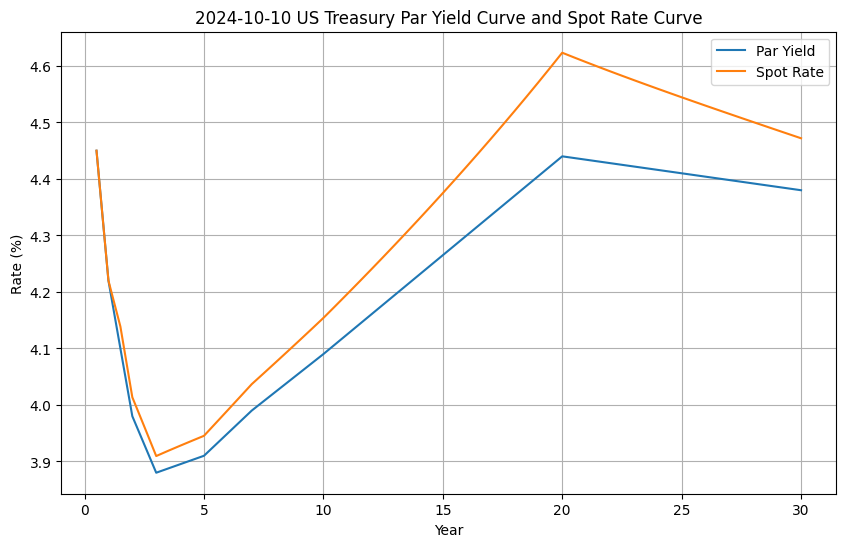

In [53]:
# Plot spot curve and yield curve on same plot
plt.figure(figsize=(10, 6))
plt.plot(spot_rates['Year'], 100 * spot_rates['Par Yield'], label='Par Yield')
plt.plot(spot_rates['Year'], 100 * spot_rates['Spot Rate'], label='Spot Rate')
plt.title(f'{start_date} US Treasury Par Yield Curve and Spot Rate Curve')
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Forward Rates from Spot Rates

In [54]:
def calculate_forward_rates(
    spot_rates: pd.DataFrame
) -> pd.DataFrame:
    """
    Given a dataframe containing spot rates of various maturities, calculate forward rates
    """
    
    # Dataframe to store forward rates
    forward_rates = []
    
    # Calculate forward rates
    for i in range(len(spot_rates) - 1):
        # Get start time and end time for forward rate
        start = spot_rates.loc[i, 'Year']
        end = spot_rates.loc[i + 1, 'Year']
        
        # Get spot rates at start and end times
        spot_rate_start = spot_rates.loc[i, 'Spot Rate']
        spot_rate_end = spot_rates.loc[i + 1, 'Spot Rate']
        
        # Calculate forward rate
        numerator = np.power(1 + spot_rate_end, end)
        denominator = np.power(1 + spot_rate_start, start)
        forward_rate = np.power(numerator / denominator, 1 / (end - start)) - 1
        
        # Append forward rate to dataframe
        forward_rates.append(
            {
                'Start Year': start,
                'End Year': end,
                'Forward Rate': forward_rate
            }
        )
    
    # Convert forward rates to df
    forward_rates = pd.DataFrame(forward_rates)
    
    return forward_rates


In [55]:
# Calculate forward rates implied by spot rates
forward_rates = calculate_forward_rates(
    spot_rates=spot_rates
)

forward_rates.head(10)

,Start Year,End Year,Forward Rate
0,0.5,1.0,0.039905
1,1.0,1.5,0.039766
2,1.5,2.0,0.036387
3,2.0,2.5,0.037550
4,2.5,3.0,0.036484
5,3.0,3.5,0.039743
6,3.5,4.0,0.039907
7,4.0,4.5,0.040073
8,4.5,5.0,0.040241
9,5.0,5.5,0.041960


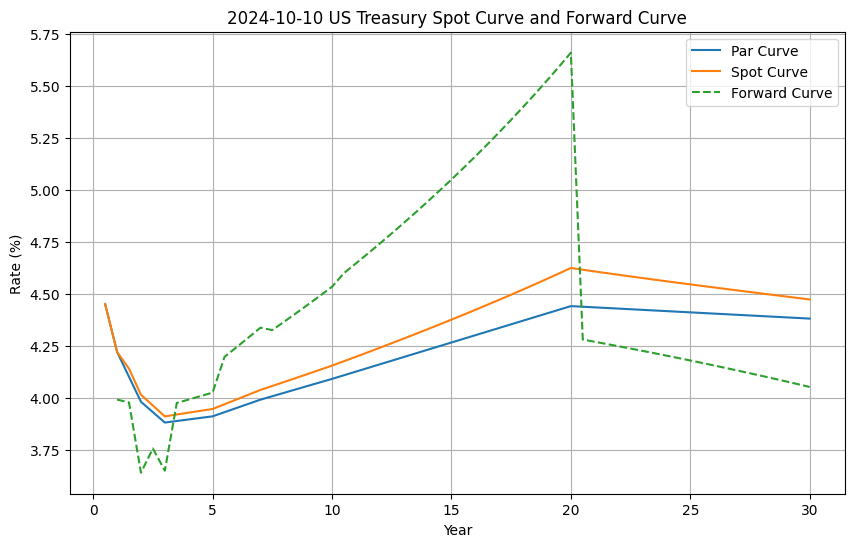

In [56]:
# Plot spot vs forward vs yield
plt.figure(figsize=(10, 6))
plt.plot(spot_rates['Year'], 100 * spot_rates['Par Yield'], label='Par Curve')
plt.plot(spot_rates['Year'], 100 * spot_rates['Spot Rate'], label='Spot Curve')
plt.plot(forward_rates['End Year'], 100 * forward_rates['Forward Rate'], linestyle='--', label='Forward Curve')
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title(f'{start_date} US Treasury Spot Curve and Forward Curve')
plt.legend()
plt.grid(True)
plt.show()

# OpenBB Logout

In [57]:
# Logout
obb.account.logout()